Data Increase + Batch normalization + Dropout + Stochastic Depth

# Libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from einops import rearrange

import torch.optim
import torch.utils.data
#!pip install torchvision==0.11.1
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
import time

# Datasets

In [2]:
from timm.models.layers import DropPath

In [3]:
PATH="datasets"

# Model

In [14]:
def imgs_to_SoP(imgs):
    shape = imgs.shape
    height = shape[-2]
    width = shape[-1]
    batch = shape[0]
    
    ind_w = torch.arange(width)/(width-1)-0.5
    ind_h = torch.arange(height)/(height-1)-0.5
    ind = torch.stack(torch.meshgrid(ind_w,ind_h,indexing = 'ij'),dim = -1).reshape(2,height,width)
    
    batch_ind = ind.repeat(batch,1,1,1)
    #flat_imgs = imgs.flatten(start_dim=len(shape)-2) #laisser en b c h w ?
    
    SoP = torch.cat((imgs,batch_ind),dim=1)
    
    return SoP

In [15]:
class GroupNorm(nn.GroupNorm):
    """
    Group Normalization with 1 group.
    Input: tensor in shape [B, C, H, W]
    """
    def __init__(self, num_channels, **kwargs):
        super().__init__(1, num_channels, **kwargs)

In [16]:
class PointReducer(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=2, stride=2, norm_layer=None):
        super().__init__()
        self.conv2d = nn.Conv2d(in_chan, out_chan, kernel_size, stride)
        self.norm = norm_layer(out_chan) if norm_layer else nn.Identity()

    def forward(self,input):
        out = self.conv2d(input)
        out = self.norm(out)
        return out

In [17]:
def pairwise_cosine_sim(x1, x2):
    x1_norm = F.normalize(x1, dim=-1) 
    x2_norm = F.normalize(x2, dim=-1)
    
    sim = x1_norm @ x2_norm.transpose(-2,-1) #to compute for each pair in the batch
    
    return sim

In [18]:
class Cluster(nn.Module):
    def __init__(self,in_channels,out_channels,heads,head_dim,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2):
        super().__init__()
        
        self.heads = heads
        self.head_dim = head_dim
        self.fold_w = fold_w
        self.fold_h = fold_h
        
        self.fc1 = nn.Conv2d(in_channels,heads*head_dim,kernel_size = 1)
            #heads*head_dim -> we place the heads in the batch later
        self.fcv = nn.Conv2d(in_channels,heads*head_dim,kernel_size = 1)
        self.fc2 = nn.Conv2d(heads*head_dim,out_channels,kernel_size = 1)
        self.center_proposal = nn.AdaptiveAvgPool2d((proposal_w,proposal_h))
        
        self.alpha = nn.Parameter(torch.ones(1)) #initialisation bizarre
        self.beta = nn.Parameter(torch.zeros(1)) #initialisation bizarre
        
    def forward(self,x):
        """
        x : [b,c,h,w]
        """
        _,_,h,w = x.shape 
        
        val = self.fcv(x)
        x = self.fc1(x)

        # separating heads
        x = rearrange(x, "b (e c) h w -> (b e) c h w", e=self.heads)
        val = rearrange(val, "b (e c) h w -> (b e) c h w", e=self.heads) 
        
        #splitting patches 
        if self.fold_w>1 and self.fold_h>1:
            assert w%self.fold_w==0 and h%self.fold_h==0
            x = rearrange(x, "b c (f1 h) (f2 w) -> (b f1 f2) c h w", f1=self.fold_h, f2=self.fold_w)
            val = rearrange(val, "b c (f1 h) (f2 w) -> (b f1 f2) c h w", f1=self.fold_h, f2=self.fold_w)
        _,_,h,w = x.shape
        #computing cluster centers
        cluster_centers = self.center_proposal(x) #(b,c,Cw,Ch)
        center_values = rearrange(self.center_proposal(val) , 'b c h w -> b (h w) c') #(b,Cw*Ch,c) = (b,m,c)
        
        b,c,_,_ = cluster_centers.shape

        #computing similarity
        sim = torch.sigmoid(self.beta + self.alpha*pairwise_cosine_sim(cluster_centers.reshape(b,c,-1).permute(0,2,1), x.reshape(b,c,-1).permute(0,2,1))) #(b,Cw*Ch,h*w) = (b,m,n)
        sim_max, sim_argmax = sim.max(dim = 1, keepdim = True)
        
        #assigning a cluster to each point
        mask = torch.zeros_like(sim) #(b,m,n)
        mask.scatter_(1, sim_argmax, 1.)
        sim= sim*mask
        
        #computing aggregated feature
        val = rearrange(val, 'b c h w -> b (h w) c')
        out = ((val.unsqueeze(dim=1)*sim.unsqueeze(dim=-1)).sum(dim=2) + center_values)/(mask.sum(dim=-1,keepdim=True)+ 1)
        
        out = (out.unsqueeze(dim=2)*sim.unsqueeze(dim=-1)).sum(dim=1)
        out = rearrange(out, "b (h w) c -> b c h w", h=h)
        
        #recovering splitted patches
        if self.fold_w>1 and self.fold_h>1:
            out = rearrange(out, "(b f1 f2) c h w -> b c (f1 h) (f2 w)", f1=self.fold_h, f2=self.fold_w)
        
        #regrouping heads
        out = rearrange(out, "(b e) c h w -> b (e c) h w", e=self.heads)
        out = self.fc2(out)

        return out

In [19]:
class MLP(nn.Module):
    def __init__(self,in_channels,hidden_channels,out_channels,act,dropout=0):
        super().__init__()
        
        layers = [nn.Conv2d(in_channels,hidden_channels,kernel_size=1),act()]
        if dropout:
            layers.append(nn.Dropout(dropout))
        layers += [nn.Conv2d(hidden_channels,out_channels,kernel_size=1),act()]
        
        self.net = nn.Sequential(*layers)
        
    def forward(self,x):
        out = self.net(x)
        return out

In [20]:
#add droppath ???
class ClusterBlock(nn.Module):
    
    def __init__(self,in_channels,act=nn.GELU,mlp_ratio=4,dropout=0,droppath=0,
                 proposal_w=2,proposal_h=2,fold_w=2,fold_h=2,
                 heads=4,head_dim=16,norm_layer=GroupNorm,ablation=False):
        super().__init__()

        #(in_channels,out_channels,heads,head_dim,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2))
        self.ablation = ablation
        
        if not ablation:
            self.cluster = Cluster(in_channels,in_channels,heads,head_dim,proposal_w,proposal_h,fold_w,fold_h)
        hidden_dim = int(mlp_ratio*in_channels)
        self.mlp = MLP(in_channels,hidden_dim,in_channels,act,dropout=dropout)
        self.norm1 = norm_layer(in_channels)
        self.norm2 = norm_layer(in_channels)
        
        self.droppath = DropPath(droppath)
        
    def forward(self,x):
        if not self.ablation:
            x = x + self.droppath(self.cluster(self.norm1(x))) #skip conn
        out = x + self.droppath(self.mlp(self.norm2(x))) #skip conn
        return out

In [21]:
class BasicBlock(nn.Module):
    def __init__(self,in_channels,out_channels,N=1,
                 heads=4,head_dim=16,mlp_ratio=4,fold=2,
                 norm_layer=GroupNorm,dropout=0,droppath=0,
                 first_layer=False,ablation=False):
        super().__init__()
        self.red = not first_layer
        if not first_layer:
            self.point_red = PointReducer(in_channels,out_channels)
        layers = []
        for i in range(N):
            layers.append(ClusterBlock(out_channels,heads=heads,head_dim=head_dim,mlp_ratio=mlp_ratio,norm_layer=norm_layer,dropout=dropout,droppath=droppath,fold_h=fold,fold_w=fold,ablation=ablation))
        self.cluster_b = nn.Sequential(*layers)
    
    def forward(self,x):
        if self.red:
            x = self.point_red(x)
        x = self.cluster_b(x)
        return x

In [22]:
class Model(nn.Module):
    def __init__(self,embedding_sizes,num_classes,n_blocks=[1,1,1,1],head_counts=[4,4,4,4],head_dims=[16,16,16,16],
                 mlp_ratios=[4,4,4,4],norm_layer=GroupNorm,dropout=0,droppath=0,ablation=False):
        super().__init__()
        layers = []
        in_channels = 5
        
        #for out_channels in embedding_sizes:
            #layers.append(BasicBlock(in_channels,out_channels,norm_layer=norm_layer,dropout=dropout))
            #in_channels = out_channels

        first_layer = True
        for stage,out_channels in enumerate(embedding_sizes):
            N = n_blocks[stage]
            heads = head_counts[stage]
            head_dim = head_dims[stage]
            mlp_ratio= mlp_ratios[stage]
            fold = folds[stage]
            
            layers.append(BasicBlock(in_channels,out_channels,N=N,heads=heads,head_dim=head_dim,mlp_ratio=mlp_ratio,
                                     fold=fold,norm_layer=norm_layer,dropout=dropout,droppath=droppath,
                                     first_layer=first_layer,ablation=ablation))
            in_channels = out_channels
            first_layer=False

        
        self.feature_extractor = nn.Sequential(*layers)
        self.clf = nn.Linear(embedding_sizes[-1],num_classes)
        self.old_shape = None


    def imgs_to_SoP(self,imgs):
        """
        Transform a batch of images to a bacth of sets of points

        imgs : torch.Tensor([batch,chan,height,width])
        return : torch.Tensor([batch,chan+2,height*width])
        """
        shape = imgs.shape
        device = imgs.device
        
        if self.old_shape != shape:
            self.old_shape = shape
            height = shape[-2]
            width = shape[-1]
            batch = shape[0]
            
            ind_w = torch.arange(width)/(width-1)-0.5
            ind_h = torch.arange(height)/(height-1)-0.5
            ind = torch.stack(torch.meshgrid(ind_w,ind_h,indexing = 'ij'),dim = -1).reshape(2,height,width)

            self.batch_ind = ind.repeat(batch,1,1,1).to(device)
        
        #flat_imgs = imgs.flatten(start_dim=len(shape)-2)
        SoP = torch.cat((imgs,self.batch_ind),dim=1) #might need to clone
        
        return SoP

    def forward(self,input):
        SoP = self.imgs_to_SoP(input)
        features = self.feature_extractor(SoP)
        features = torch.mean(features, dim = (2,3))
        yhat = self.clf(features)
        return yhat

# Tests

In [26]:
def main_100(model,n_epochs,device):
    cuda = True

    batch_size = 128
    train_dataset = datasets.CIFAR100(PATH, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor (), # Transform the PIL image to a torch.Tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.RandomErasing(),
        transforms.RandomHorizontalFlip(),
    ]))
    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=1)
    
    test_dataset = datasets.CIFAR100(PATH, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor (), # Transform the PIL image to a torch.Tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]))
    test_loader = torch.utils.data.DataLoader(test_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=1)
    

    Loss = nn.CrossEntropyLoss(label_smoothing=0.1)
    optim = torch.optim.AdamW(model.parameters(),weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim,25,eta_min=1e-5)
    
    List_Loss = []
    List_acc = []
    
    for epoch in range(n_epochs):
        model.train()
        losses = []
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            optim.zero_grad()
            
            yhat = model(X)

            l = Loss(yhat,y)
            l.backward()
            
            optim.step()
            losses.append(l.detach().cpu())
        scheduler.step()
        
        if epoch % 5 == 0:
            acc = 0
            total = 0
            model.eval()
            for X,y in test_loader:
                X,y = X.to(device), y.to(device)
                yhat = model(X)

                y_pred = torch.argmax(yhat,dim = 1)
                acc += torch.sum(y==y_pred).detach()
                total += len(y)
                #l = Loss(yhat,y)
            List_acc.append(acc.item()/total)
            
        List_Loss.append(torch.mean(torch.stack(losses)).detach().cpu())
        if epoch % 5 == 0:
            print(f"epoch n°{epoch} : loss = {List_Loss[-1]}, acc = {acc.item()/total}")
        else:
            print(f"epoch n°{epoch} : loss = {List_Loss[-1]}")
    
    plt.figure()
    plt.plot(range(n_epochs),List_Loss)
    plt.show()
    plt.close()

    
    plt.figure()
    plt.plot(range(len(List_acc)),List_acc)
    plt.show()
    plt.close()
    

In [27]:
n_blocks = [4,6,4]
embedding_sizes = [5,32,128]
head_counts = [4,4,8]
head_dims = [16,16,16]
mlp_ratios = [16,8,4]
folds = [2,1,1]
num_classes = 100
device = 'cuda'
model2 = Model(embedding_sizes,num_classes,n_blocks=n_blocks,head_counts=head_counts,head_dims=head_dims,mlp_ratios=mlp_ratios,dropout=0.5,droppath=0.2).to(device)
summary(model2,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         GroupNorm-1            [-1, 5, 32, 32]              10
            Conv2d-2           [-1, 64, 32, 32]             384
            Conv2d-3           [-1, 64, 32, 32]             384
 AdaptiveAvgPool2d-4             [-1, 16, 2, 2]               0
 AdaptiveAvgPool2d-5             [-1, 16, 2, 2]               0
            Conv2d-6            [-1, 5, 32, 32]             325
           Cluster-7            [-1, 5, 32, 32]               0
          DropPath-8            [-1, 5, 32, 32]               0
         GroupNorm-9            [-1, 5, 32, 32]              10
           Conv2d-10           [-1, 80, 32, 32]             480
             GELU-11           [-1, 80, 32, 32]               0
          Dropout-12           [-1, 80, 32, 32]               0
           Conv2d-13            [-1, 5, 32, 32]             405
             GELU-14            [-1, 5,

Files already downloaded and verified
Files already downloaded and verified
epoch n°0 : loss = 4.168618202209473, acc = 0.1224
epoch n°1 : loss = 3.870548725128174
epoch n°2 : loss = 3.6813366413116455
epoch n°3 : loss = 3.5476183891296387
epoch n°4 : loss = 3.4387216567993164
epoch n°5 : loss = 3.351649522781372, acc = 0.3004
epoch n°6 : loss = 3.2680888175964355
epoch n°7 : loss = 3.2028446197509766
epoch n°8 : loss = 3.140186071395874
epoch n°9 : loss = 3.077803373336792
epoch n°10 : loss = 3.028599977493286, acc = 0.3787
epoch n°11 : loss = 2.9846129417419434
epoch n°12 : loss = 2.939422845840454
epoch n°13 : loss = 2.9039340019226074
epoch n°14 : loss = 2.870450258255005
epoch n°15 : loss = 2.8355696201324463, acc = 0.4207
epoch n°16 : loss = 2.8093645572662354
epoch n°17 : loss = 2.783003330230713
epoch n°18 : loss = 2.7627904415130615
epoch n°19 : loss = 2.743988513946533
epoch n°20 : loss = 2.7260849475860596, acc = 0.4441
epoch n°21 : loss = 2.717695951461792
epoch n°22 : loss

epoch n°195 : loss = 2.256594181060791, acc = 0.5472
epoch n°196 : loss = 2.269386053085327
epoch n°197 : loss = 2.2785885334014893
epoch n°198 : loss = 2.276662588119507
epoch n°199 : loss = 2.279827833175659
epoch n°200 : loss = 2.2808501720428467, acc = 0.5468
epoch n°201 : loss = 2.281906843185425
epoch n°202 : loss = 2.2799065113067627
epoch n°203 : loss = 2.2720999717712402
epoch n°204 : loss = 2.2618982791900635
epoch n°205 : loss = 2.251748561859131, acc = 0.5515
epoch n°206 : loss = 2.250107765197754
epoch n°207 : loss = 2.2304441928863525
epoch n°208 : loss = 2.212148904800415
epoch n°209 : loss = 2.2007267475128174
epoch n°210 : loss = 2.181163787841797, acc = 0.5661
epoch n°211 : loss = 2.1592419147491455
epoch n°212 : loss = 2.1479172706604004
epoch n°213 : loss = 2.1235318183898926
epoch n°214 : loss = 2.108499526977539
epoch n°215 : loss = 2.0897350311279297, acc = 0.5832
epoch n°216 : loss = 2.072920322418213
epoch n°217 : loss = 2.0533018112182617
epoch n°218 : loss = 

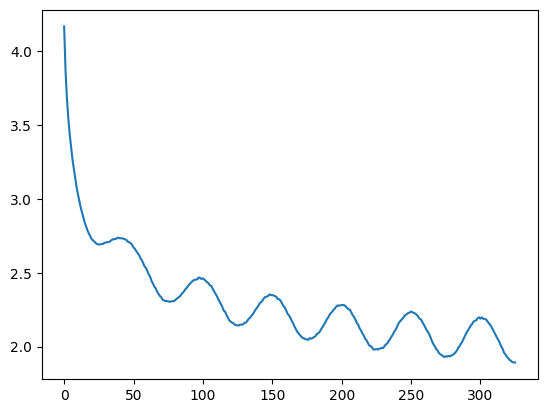

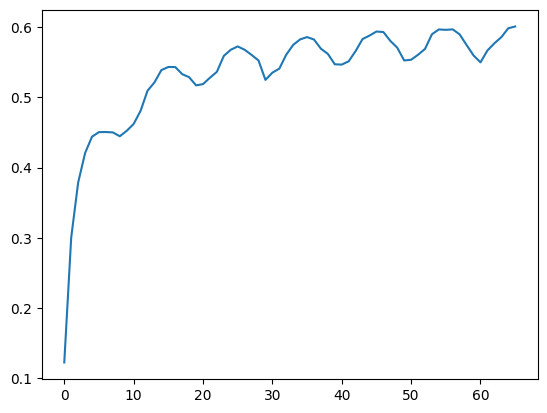

24376.47040271759
74.77444908809076


In [29]:
n_ep = 326
start = time.time()
main_100(model2,n_ep,device)
stop = time.time()
print(stop-start)
print((stop-start)/n_ep)

In [30]:
torch.save(model2.state_dict(), "model_super_small_100.pth")

In [31]:
n_blocks = [4,6,4]
embedding_sizes = [5,32,128]
head_counts = [4,4,8]
head_dims = [16,16,16]
mlp_ratios = [16,8,4]
folds = [2,1,1]
num_classes = 100
device = 'cuda'
model2 = Model(embedding_sizes,num_classes,ablation=True,n_blocks=n_blocks,head_counts=head_counts,head_dims=head_dims,mlp_ratios=mlp_ratios,dropout=0.5,droppath=0.2).to(device)
summary(model2,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         GroupNorm-1            [-1, 5, 32, 32]              10
            Conv2d-2           [-1, 80, 32, 32]             480
              GELU-3           [-1, 80, 32, 32]               0
           Dropout-4           [-1, 80, 32, 32]               0
            Conv2d-5            [-1, 5, 32, 32]             405
              GELU-6            [-1, 5, 32, 32]               0
               MLP-7            [-1, 5, 32, 32]               0
          DropPath-8            [-1, 5, 32, 32]               0
      ClusterBlock-9            [-1, 5, 32, 32]               0
        GroupNorm-10            [-1, 5, 32, 32]              10
           Conv2d-11           [-1, 80, 32, 32]             480
             GELU-12           [-1, 80, 32, 32]               0
          Dropout-13           [-1, 80, 32, 32]               0
           Conv2d-14            [-1, 5,

Files already downloaded and verified
Files already downloaded and verified
epoch n°0 : loss = 4.150847434997559, acc = 0.1278
epoch n°1 : loss = 3.8804025650024414
epoch n°2 : loss = 3.7213244438171387
epoch n°3 : loss = 3.5840117931365967
epoch n°4 : loss = 3.471791982650757
epoch n°5 : loss = 3.3833746910095215, acc = 0.2849
epoch n°6 : loss = 3.31230092048645
epoch n°7 : loss = 3.2374134063720703
epoch n°8 : loss = 3.177663803100586
epoch n°9 : loss = 3.128258466720581
epoch n°10 : loss = 3.079516887664795, acc = 0.359
epoch n°11 : loss = 3.037972927093506
epoch n°12 : loss = 3.007786273956299
epoch n°13 : loss = 2.968808889389038
epoch n°14 : loss = 2.9371047019958496
epoch n°15 : loss = 2.910465717315674, acc = 0.4032
epoch n°16 : loss = 2.8886892795562744
epoch n°17 : loss = 2.864943742752075
epoch n°18 : loss = 2.8521933555603027
epoch n°19 : loss = 2.8350236415863037
epoch n°20 : loss = 2.8220317363739014, acc = 0.4212
epoch n°21 : loss = 2.8070452213287354
epoch n°22 : loss =

epoch n°195 : loss = 2.426556348800659, acc = 0.5141
epoch n°196 : loss = 2.4388139247894287
epoch n°197 : loss = 2.438058853149414
epoch n°198 : loss = 2.443812131881714
epoch n°199 : loss = 2.4436471462249756
epoch n°200 : loss = 2.441228151321411, acc = 0.5174
epoch n°201 : loss = 2.4422435760498047
epoch n°202 : loss = 2.443253755569458
epoch n°203 : loss = 2.440352201461792
epoch n°204 : loss = 2.4289114475250244
epoch n°205 : loss = 2.425442934036255, acc = 0.5168
epoch n°206 : loss = 2.4191181659698486
epoch n°207 : loss = 2.408655881881714
epoch n°208 : loss = 2.3811910152435303
epoch n°209 : loss = 2.3806111812591553
epoch n°210 : loss = 2.367854595184326, acc = 0.5251
epoch n°211 : loss = 2.350430488586426
epoch n°212 : loss = 2.339721441268921
epoch n°213 : loss = 2.3270442485809326
epoch n°214 : loss = 2.309880018234253
epoch n°215 : loss = 2.2937121391296387, acc = 0.543
epoch n°216 : loss = 2.2830090522766113
epoch n°217 : loss = 2.2640295028686523
epoch n°218 : loss = 2.

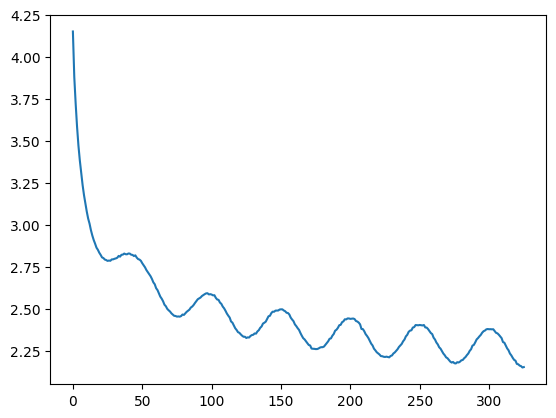

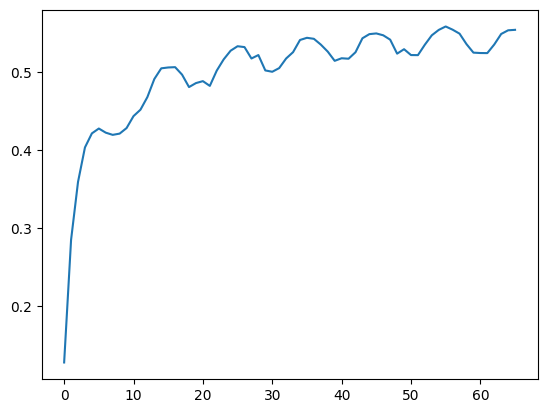

7658.685036659241
23.492898885457794


In [32]:
n_ep = 326
start = time.time()
main_100(model2,n_ep,device)
stop = time.time()
print(stop-start)
print((stop-start)/n_ep)

In [33]:
torch.save(model2.state_dict(), "model_super_small_ablated_100.pth")